In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [21]:
path_cwd = os.getcwd()

Do countries with a higher share of organic agricultural area demonstrate higher or lower overall agricultural output or value-added per unit of land?

In [22]:
# Read the datasets
df_organic = pd.read_csv('EUROSTAT/Agricultural_Holdings_With_Organic_Area.tsv', sep='\t')
df_output = pd.read_csv('EUROSTAT/Output_of_the_agricultural_industry_basic_and_producer_prices_.tsv', sep='\t')
df_land_use = pd.read_csv('EUROSTAT/Farm_Land_Use.tsv', sep='\t')


In [23]:

# 1. Clean the land use data

# Rename the first column
df_land_use = df_land_use.rename(columns={df_land_use.columns[0]: 'metadata'})

# Split the metadata column
metadata_split = df_land_use['metadata'].str.split(',', expand=True)
df_land_use['freq'] = metadata_split[0]
df_land_use['so_eur'] = metadata_split[1]
df_land_use['crops'] = metadata_split[2]
df_land_use['unit'] = metadata_split[3]
df_land_use['geo_time'] = metadata_split[4]

# Split geo and time
df_land_use['geo'] = df_land_use['geo_time'].str.split('\\').str[0]
df_land_use['time_period'] = df_land_use['geo_time'].str.split('\\').str[1] if '\\' in df_land_use['geo_time'].iloc[0] else 'TIME_PERIOD'

# Clean year column names 
df_land_use.columns = [col.strip() if isinstance(col, str) else col for col in df_land_use.columns]

# Get year columns
year_cols = [col for col in df_land_use.columns if col.isdigit()]

# Filter for organic area and total UAA
organic_area = df_land_use[df_land_use['crops'] == 'UAAXK0000_ORG'].copy()
total_uua = df_land_use[df_land_use['crops'] == 'UAA'].copy()

# Melt organic area data
organic_melted = organic_area.melt(id_vars=['geo', 'crops'], 
                                  value_vars=year_cols,
                                  var_name='year', 
                                  value_name='organic_area_ha')
organic_melted['year'] = organic_melted['year'].astype(int)

# Melt total UAA data
total_uua_melted = total_uua.melt(id_vars=['geo', 'crops'],
                                 value_vars=year_cols,
                                 var_name='year',
                                 value_name='total_uua_ha')
total_uua_melted['year'] = total_uua_melted['year'].astype(int)

# Clean numeric values
def clean_numeric(value):
    if isinstance(value, str):
        value = value.strip()
        if value in [':', '', 'nan', 'NaN']:
            return np.nan
        # Remove flags 
        value = value.replace('i', '').replace('u', '').replace('e', '').replace('@', '').replace('C', '')
        try:
            return float(value)
        except:
            return np.nan
    return value

organic_melted['organic_area_ha'] = organic_melted['organic_area_ha'].apply(clean_numeric)
total_uua_melted['total_uua_ha'] = total_uua_melted['total_uua_ha'].apply(clean_numeric)

# Merge and calculate organic share
organic_data = pd.merge(organic_melted[['geo', 'year', 'organic_area_ha']],
                       total_uua_melted[['geo', 'year', 'total_uua_ha']],
                       on=['geo', 'year'], how='inner')
organic_data['organic_share'] = organic_data['organic_area_ha'] / organic_data['total_uua_ha']


In [24]:

# 2. Clean output data

df_output = df_output.rename(columns={df_output.columns[0]: 'metadata'})
metadata_split_output = df_output['metadata'].str.split(',', expand=True)
df_output['freq'] = metadata_split_output[0]
df_output['itm_newa'] = metadata_split_output[1]
df_output['indic_ag'] = metadata_split_output[2]
df_output['unit'] = metadata_split_output[3]
df_output['geo_time'] = metadata_split_output[4]

df_output['geo'] = df_output['geo_time'].str.split('\\').str[0]
df_output.columns = [col.strip() if isinstance(col, str) else col for col in df_output.columns]

# Get year columns for output
output_year_cols = [col for col in df_output.columns if col.isdigit()]

# Filter for basic prices 
output_data = df_output[df_output['indic_ag'] == 'PROD_BP'].copy()

# Melt output data
output_melted = output_data.melt(id_vars=['geo', 'indic_ag'],
                                value_vars=output_year_cols,
                                var_name='year',
                                value_name='output_mio_eur')
output_melted['year'] = output_melted['year'].astype(int)
output_melted['output_mio_eur'] = output_melted['output_mio_eur'].apply(clean_numeric)
output_melted['output_eur'] = output_melted['output_mio_eur'] * 1000000  # Convert to EUR


In [25]:

# 3. Merge all data

# Merge output with total UAA 
output_with_area = pd.merge(output_melted[['geo', 'year', 'output_eur']],
                           total_uua_melted[['geo', 'year', 'total_uua_ha']],
                           on=['geo', 'year'], how='inner')

# Calculate output per hectare
output_with_area['output_per_ha'] = output_with_area['output_eur'] / output_with_area['total_uua_ha']

# Merge with organic share
final_data = pd.merge(organic_data[['geo', 'year', 'organic_share']],
                      output_with_area[['geo', 'year', 'output_per_ha']],
                      on=['geo', 'year'], how='inner')

# Remove missing values
final_data = final_data.dropna()

print(f"Total observations: {len(final_data)}")
print(f"Countries: {final_data['geo'].nunique()}")
print(f"Years: {final_data['year'].min()} to {final_data['year'].max()}")


Total observations: 110
Countries: 32
Years: 2013 to 2023



Overall correlation: -0.173


C:\Users\domin\AppData\Local\Temp\ipykernel_10888\1282478628.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_data['organic_group'] = pd.qcut(latest_data['organic_share'], q=4,
C:\Users\domin\AppData\Local\Temp\ipykernel_10888\1282478628.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=labels)


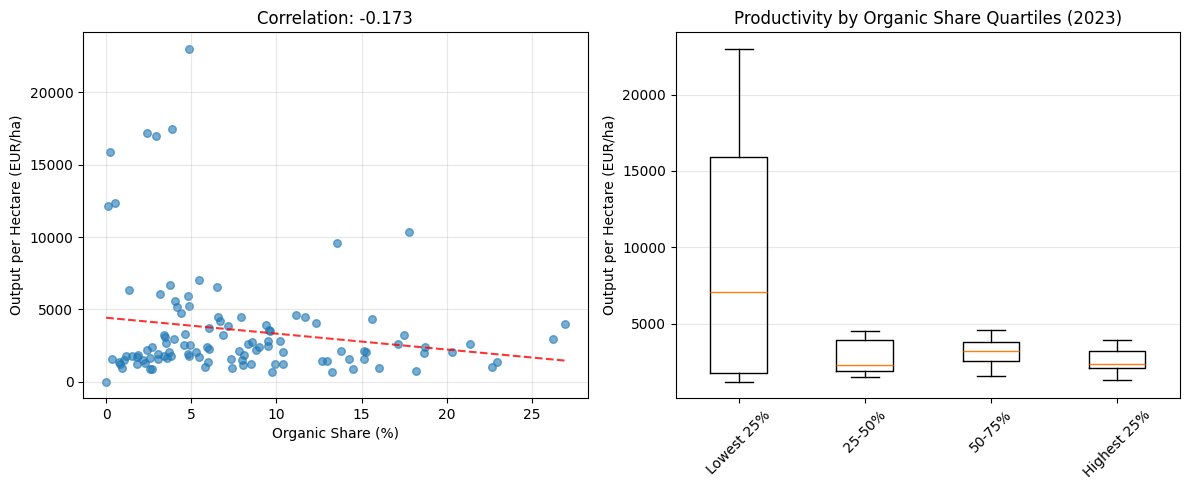

In [26]:

# 4. Analysis

# Correlation
correlation = final_data['organic_share'].corr(final_data['output_per_ha'])
print(f"\nOverall correlation: {correlation:.3f}")


# Visualization
plt.figure(figsize=(12, 5))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(final_data['organic_share'] * 100, final_data['output_per_ha'], 
           alpha=0.6, s=30)
plt.xlabel('Organic Share (%)')
plt.ylabel('Output per Hectare (EUR/ha)')
plt.title(f'Correlation: {correlation:.3f}')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(final_data['organic_share'] * 100, final_data['output_per_ha'], 1)
p = np.poly1d(z)
x_range = np.linspace(0, final_data['organic_share'].max() * 100, 100)
plt.plot(x_range, p(x_range), "r--", alpha=0.8)

# Box plot comparison
plt.subplot(1, 2, 2)
latest_year = final_data['year'].max()
latest_data = final_data[final_data['year'] == latest_year]

# Create groups
latest_data['organic_group'] = pd.qcut(latest_data['organic_share'], q=4, 
                                      labels=['Lowest 25%', '25-50%', '50-75%', 'Highest 25%'])

# Data for box plot
box_data = []
labels = []
for group in ['Lowest 25%', '25-50%', '50-75%', 'Highest 25%']:
    group_data = latest_data[latest_data['organic_group'] == group]['output_per_ha']
    if len(group_data) > 0:
        box_data.append(group_data)
        labels.append(group)

plt.boxplot(box_data, labels=labels)
plt.ylabel('Output per Hectare (EUR/ha)')
plt.title(f'Productivity by Organic Share Quartiles ({latest_year})')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [27]:

# 5. Results

# Top and bottom performers
print(f"\nTop 5 by organic share:")
top5 = latest_data.nlargest(5, 'organic_share')
for i, (_, row) in enumerate(top5.iterrows(), 1):
    print(f"{i}. {row['geo']}: {row['organic_share']*100:.1f}% organic, {row['output_per_ha']:.0f} EUR/ha")

print(f"\nBottom 5 by organic share:")
bottom5 = latest_data.nsmallest(5, 'organic_share')
for i, (_, row) in enumerate(bottom5.iterrows(), 1):
    print(f"{i}. {row['geo']}: {row['organic_share']*100:.1f}% organic, {row['output_per_ha']:.0f} EUR/ha")

# Summary statistics
print(f"\nSummary Statistics ({latest_year}):")
print(f"Average organic share: {latest_data['organic_share'].mean()*100:.1f}%")
print(f"Median organic share: {latest_data['organic_share'].median()*100:.1f}%")
print(f"Average output per hectare: {latest_data['output_per_ha'].mean():.0f} EUR/ha")
print(f"Median output per hectare: {latest_data['output_per_ha'].median():.0f} EUR/ha")

# Top vs bottom quartile
top_quartile = latest_data[latest_data['organic_group'] == 'Highest 25%']
bottom_quartile = latest_data[latest_data['organic_group'] == 'Lowest 25%']

print(f"\nComparison of highest vs lowest organic quartile:")
print(f"Highest 25% organic: {len(top_quartile)} countries, avg output: {top_quartile['output_per_ha'].mean():.0f} EUR/ha")
print(f"Lowest 25% organic: {len(bottom_quartile)} countries, avg output: {bottom_quartile['output_per_ha'].mean():.0f} EUR/ha")
difference = top_quartile['output_per_ha'].mean() - bottom_quartile['output_per_ha'].mean()
print(f"Difference: {difference:+.0f} EUR/ha ({difference/bottom_quartile['output_per_ha'].mean()*100:+.1f}%)")

# 6. Time trend analysis 
if final_data['year'].nunique() > 1:
    
    # Calculate average organic share and output per year
    yearly_stats = final_data.groupby('year').agg({
        'organic_share': 'mean',
        'output_per_ha': 'mean'
    }).reset_index()
    
    print(f"\nYearly averages:")
    for _, row in yearly_stats.iterrows():
        print(f"{row['year']}: {row['organic_share']*100:.1f}% organic, {row['output_per_ha']:.0f} EUR/ha")
    
    # Calculate changes
    if len(yearly_stats) >= 2:
        first_year = yearly_stats['year'].min()
        last_year = yearly_stats['year'].max()
        
        first_row = yearly_stats[yearly_stats['year'] == first_year].iloc[0]
        last_row = yearly_stats[yearly_stats['year'] == last_year].iloc[0]
        
        organic_change = (last_row['organic_share'] - first_row['organic_share']) / first_row['organic_share'] * 100
        output_change = (last_row['output_per_ha'] - first_row['output_per_ha']) / first_row['output_per_ha'] * 100
        
        print(f"\nChange from {first_year} to {last_year}:")
        print(f"Organic share: {organic_change:+.1f}%")
        print(f"Output per hectare: {output_change:+.1f}%")



Top 5 by organic share:
1. AT: 26.9% organic, 3963 EUR/ha
2. EE: 22.9% organic, 1342 EUR/ha
3. SE: 18.7% organic, 2391 EUR/ha
4. PT: 17.5% organic, 3243 EUR/ha
5. CZ: 15.3% organic, 2092 EUR/ha

Bottom 5 by organic share:
1. MT: 0.2% organic, 15893 EUR/ha
2. BG: 1.8% organic, 1221 EUR/ha
3. NL: 4.9% organic, 22984 EUR/ha
4. RO: 4.9% organic, 1770 EUR/ha
5. CY: 5.5% organic, 7053 EUR/ha

Summary Statistics (2023):
Average organic share: 10.6%
Median organic share: 9.4%
Average output per hectare: 4668 EUR/ha
Median output per hectare: 2843 EUR/ha

Comparison of highest vs lowest organic quartile:
Highest 25% organic: 5 countries, avg output: 2606 EUR/ha
Lowest 25% organic: 5 countries, avg output: 9784 EUR/ha
Difference: -7178 EUR/ha (-73.4%)

Yearly averages:
2013.0: 5.5% organic, 3316 EUR/ha
2016.0: 7.4% organic, 3121 EUR/ha
2020.0: 8.9% organic, 3563 EUR/ha
2023.0: 10.6% organic, 4668 EUR/ha

Change from 2013 to 2023:
Organic share: +91.1%
Output per hectare: +40.8%


Is there a relationship between farm manager training/age and the adoption of organic farming, higher-value production, or better economic results?

In [28]:
# Datasets
df_manager_age = pd.read_csv('EUROSTAT/Agricultural_Holdings_By_Manager_Age.tsv', sep='\t')
df_manager_training = pd.read_csv('EUROSTAT/Agricultural_Holdings_By_Manager_Training.tsv', sep='\t')
df_organic = pd.read_csv('EUROSTAT/Agricultural_Holdings_With_Organic_Area.tsv', sep='\t')
df_output = pd.read_csv('EUROSTAT/Output_of_the_agricultural_industry_basic_and_producer_prices_.tsv', sep='\t')
df_land_use = pd.read_csv('EUROSTAT/Farm_Land_Use.tsv', sep='\t')


In [29]:

# Function to clean numeric values
def clean_numeric(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        value = value.strip()
        if value in [':', '', 'nan', 'NaN', 'NAN']:
            return np.nan
        # Remove flags
        value = value.replace('i', '').replace('u', '').replace('e', '').replace('@', '').replace('C', '')
        try:
            return float(value)
        except:
            return np.nan
    return value

# 1. Process Manager Age Data 

# Rename first column
df_age = df_manager_age.rename(columns={df_manager_age.columns[0]: 'metadata'})

# Split metadata
metadata_split = df_age['metadata'].str.split(',', expand=True)
df_age['freq'] = metadata_split[0]
df_age['so_eur'] = metadata_split[1]
df_age['sex'] = metadata_split[2]
df_age['age'] = metadata_split[3]
df_age['unit'] = metadata_split[4]
df_age['geo_time'] = metadata_split[5]

# Get geo code
df_age['geo'] = df_age['geo_time'].str.split('\\').str[0]

# Clean column names
df_age.columns = [str(col).strip() for col in df_age.columns]

# Get year columns
age_year_cols = [col for col in df_age.columns if col.isdigit()]

# Filter for relevant data: TOTAL sex and TOTAL age and young age groups
df_age_total = df_age[(df_age['sex'] == 'T') & (df_age['age'] == 'TOTAL')].copy()
df_age_young = df_age[(df_age['sex'] == 'T') & (df_age['age'].isin(['Y_LT25', 'Y25-34', 'Y35-39', 'Y40-44']))].copy()

# Melt total holders data
age_total_melted = df_age_total.melt(id_vars=['geo', 'age'], 
                                     value_vars=age_year_cols,
                                     var_name='year', 
                                     value_name='total_holders')
age_total_melted['year'] = age_total_melted['year'].astype(int)
age_total_melted['total_holders'] = age_total_melted['total_holders'].apply(clean_numeric)

# Melt young holders data
age_young_melted = df_age_young.melt(id_vars=['geo', 'age'], 
                                     value_vars=age_year_cols,
                                     var_name='year', 
                                     value_name='young_holders')
age_young_melted['year'] = age_young_melted['year'].astype(int)
age_young_melted['young_holders'] = age_young_melted['young_holders'].apply(clean_numeric)

# Sum all young age groups per country/year
young_summary = age_young_melted.groupby(['geo', 'year'])['young_holders'].sum().reset_index()

# Merge with total holders
age_data = pd.merge(young_summary, 
                    age_total_melted[['geo', 'year', 'total_holders']],
                    on=['geo', 'year'], how='inner')

# Calculate young manager share (under 45)
age_data['young_share'] = age_data['young_holders'] / age_data['total_holders']


In [30]:

# 2.  Organic Data

# Clean organic data
df_org = df_organic.rename(columns={df_organic.columns[0]: 'metadata'})
metadata_split_org = df_org['metadata'].str.split(',', expand=True)
df_org['freq'] = metadata_split_org[0]
df_org['uaarea'] = metadata_split_org[1]
df_org['so_eur'] = metadata_split_org[2]
df_org['farmtype'] = metadata_split_org[3]
df_org['crops'] = metadata_split_org[4]
df_org['unit'] = metadata_split_org[5]
df_org['geo_time'] = metadata_split_org[6]
df_org['geo'] = df_org['geo_time'].str.split('\\').str[0]

# Clean column names
df_org.columns = [str(col).strip() for col in df_org.columns]
org_year_cols = [col for col in df_org.columns if col.isdigit()]

# Filter for organic holdings
org_data = df_org[df_org['crops'] == 'UAAXK0000_ORG'].copy()

# Melt organic data
org_melted = org_data.melt(id_vars=['geo', 'crops'], 
                           value_vars=org_year_cols,
                           var_name='year', 
                           value_name='organic_holdings')
org_melted['year'] = org_melted['year'].astype(int)
org_melted['organic_holdings'] = org_melted['organic_holdings'].apply(clean_numeric)


In [31]:

# 3. Data for Economic Results

# Clean output data
df_out = df_output.rename(columns={df_output.columns[0]: 'metadata'})
metadata_split_out = df_out['metadata'].str.split(',', expand=True)
df_out['freq'] = metadata_split_out[0]
df_out['itm_newa'] = metadata_split_out[1]
df_out['indic_ag'] = metadata_split_out[2]
df_out['unit'] = metadata_split_out[3]
df_out['geo_time'] = metadata_split_out[4]
df_out['geo'] = df_out['geo_time'].str.split('\\').str[0]

# Clean column names
df_out.columns = [str(col).strip() for col in df_out.columns]
out_year_cols = [col for col in df_out.columns if col.isdigit()]

# Get output value (basic prices)
output_data = df_out[df_out['indic_ag'] == 'PROD_BP'].copy()

# Melt output data
output_melted = output_data.melt(id_vars=['geo'], 
                                 value_vars=out_year_cols,
                                 var_name='year', 
                                 value_name='output_mio_eur')
output_melted['year'] = output_melted['year'].astype(int)
output_melted['output_mio_eur'] = output_melted['output_mio_eur'].apply(clean_numeric)
output_melted['output_eur'] = output_melted['output_mio_eur'] * 1000000


In [32]:

# 4. Land Use Data for area

# Clean land use data
df_land = df_land_use.rename(columns={df_land_use.columns[0]: 'metadata'})
metadata_split_land = df_land['metadata'].str.split(',', expand=True)
df_land['freq'] = metadata_split_land[0]
df_land['so_eur'] = metadata_split_land[1]
df_land['crops'] = metadata_split_land[2]
df_land['unit'] = metadata_split_land[3]
df_land['geo_time'] = metadata_split_land[4]
df_land['geo'] = df_land['geo_time'].str.split('\\').str[0]

# Clean column names
df_land.columns = [str(col).strip() for col in df_land.columns]
land_year_cols = [col for col in df_land.columns if col.isdigit()]

# Get total UAA
land_total = df_land[df_land['crops'] == 'UAA'].copy()

# Melt land data
land_melted = land_total.melt(id_vars=['geo'], 
                              value_vars=land_year_cols,
                              var_name='year', 
                              value_name='total_uua_ha')
land_melted['year'] = land_melted['year'].astype(int)
land_melted['total_uua_ha'] = land_melted['total_uua_ha'].apply(clean_numeric)


In [33]:

# 5. Merge All Data

# Start with age data
merged_data = age_data[['geo', 'year', 'young_share']].copy()

# Merge with organic
merged_data = pd.merge(merged_data, 
                       org_melted[['geo', 'year', 'organic_holdings']],
                       on=['geo', 'year'], how='inner')

# Merge with land area
merged_data = pd.merge(merged_data, 
                       land_melted[['geo', 'year', 'total_uua_ha']],
                       on=['geo', 'year'], how='inner')

# Merge with output
merged_data = pd.merge(merged_data, 
                       output_melted[['geo', 'year', 'output_eur']],
                       on=['geo', 'year'], how='inner')

# Calculate derived metrics
# Organic share = organic holdings / total UAA (approximate)
merged_data['organic_share'] = merged_data['organic_holdings'] / merged_data['total_uua_ha']
merged_data['output_per_ha'] = merged_data['output_eur'] / merged_data['total_uua_ha']

# Remove rows with missing data
merged_data = merged_data.dropna()

print(f"\nData ready for analysis!")
print(f"Total observations: {len(merged_data)}")
print(f"Countries: {merged_data['geo'].nunique()}")
print(f"Years: {merged_data['year'].min()} to {merged_data['year'].max()}")

# 6. Analysis

# Get latest year data
latest_year = merged_data['year'].max()
latest_data = merged_data[merged_data['year'] == latest_year].copy()

print(f"\nAnalysis for {latest_year}:")
print(f"Countries: {len(latest_data)}")

# Correlation
corr_organic = latest_data['young_share'].corr(latest_data['organic_share'])
corr_output = latest_data['young_share'].corr(latest_data['output_per_ha'])

print(f"\nCorrelations:")
print(f"Young managers vs Organic share: {corr_organic:.3f}")
print(f"Young managers vs Output per hectare: {corr_output:.3f}")



Data ready for analysis!
Total observations: 110
Countries: 32
Years: 2013 to 2023

Analysis for 2023:
Countries: 19

Correlations:
Young managers vs Organic share: -0.244
Young managers vs Output per hectare: -0.244


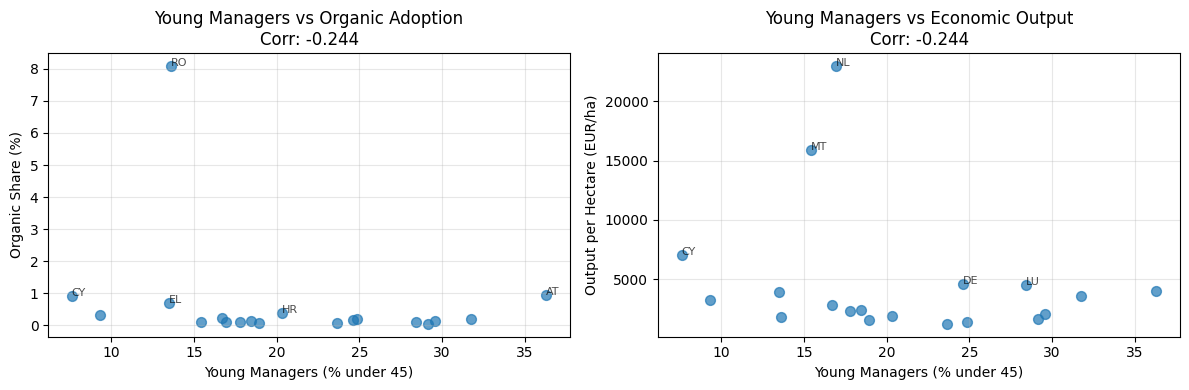

In [34]:

# 7. Visualization
plt.figure(figsize=(12, 4))

# Plot 1: Young managers vs Organic
plt.subplot(1, 2, 1)
plt.scatter(latest_data['young_share'] * 100, 
            latest_data['organic_share'] * 100, 
            alpha=0.7, s=50)
plt.xlabel('Young Managers (% under 45)')
plt.ylabel('Organic Share (%)')
plt.title(f'Young Managers vs Organic Adoption\nCorr: {corr_organic:.3f}')
plt.grid(True, alpha=0.3)

top_organic = latest_data.nlargest(5, 'organic_share')
for _, row in top_organic.iterrows():
    plt.text(row['young_share'] * 100, row['organic_share'] * 100, 
             row['geo'], fontsize=8, alpha=0.7)

# Plot 2: Young managers vs Output
plt.subplot(1, 2, 2)
plt.scatter(latest_data['young_share'] * 100, 
            latest_data['output_per_ha'], 
            alpha=0.7, s=50)
plt.xlabel('Young Managers (% under 45)')
plt.ylabel('Output per Hectare (EUR/ha)')
plt.title(f'Young Managers vs Economic Output\nCorr: {corr_output:.3f}')
plt.grid(True, alpha=0.3)

top_output = latest_data.nlargest(5, 'output_per_ha')
for _, row in top_output.iterrows():
    plt.text(row['young_share'] * 100, row['output_per_ha'], 
             row['geo'], fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
# 8. Analysis

# Compare top and bottom quartiles by young manager share
latest_data['young_quartile'] = pd.qcut(latest_data['young_share'], q=2, 
                                       labels=['Bottom 50%', 'Top 50%'])

young_stats = latest_data.groupby('young_quartile').agg({
    'organic_share': 'mean',
    'output_per_ha': 'mean',
    'geo': 'count'
}).round(4)

print(f"\nAverage values:")
print(f"{'':<15} {'Countries':<10} {'Organic %':<12} {'Output EUR/ha':<15}")
print("-" * 50)
for quartile in ['Bottom 50%', 'Top 50%']:
    stats = young_stats.loc[quartile]
    print(f"{quartile:<15} {int(stats['geo']):<10} {stats['organic_share']*100:.1f}%{'':<4} {stats['output_per_ha']:.0f}")



Average values:
                Countries  Organic %    Output EUR/ha  
--------------------------------------------------
Bottom 50%      10         1.1%     6391
Top 50%         9          0.2%     2755


C:\Users\domin\AppData\Local\Temp\ipykernel_10888\3791994956.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  young_stats = latest_data.groupby('young_quartile').agg({


In [36]:

# 9. Examples
print("\n" + "="*70)
print("COUNTRY EXAMPLES")

print(f"\nTop 5 countries by young manager share:")
top_young = latest_data.nlargest(5, 'young_share')
for i, (_, row) in enumerate(top_young.iterrows(), 1):
    print(f"{i}. {row['geo']}: {row['young_share']*100:.1f}% young, "
          f"{row['organic_share']*100:.1f}% organic, "
          f"{row['output_per_ha']:.0f} EUR/ha")

print(f"\nBottom 5 countries by young manager share:")
bottom_young = latest_data.nsmallest(5, 'young_share')
for i, (_, row) in enumerate(bottom_young.iterrows(), 1):
    print(f"{i}. {row['geo']}: {row['young_share']*100:.1f}% young, "
          f"{row['organic_share']*100:.1f}% organic, "
          f"{row['output_per_ha']:.0f} EUR/ha")

# 10. Summary

print(f"\n3. FINDINGS:")
print(f"   Countries with most young managers have {young_stats.loc['Top 50%', 'organic_share']*100:.1f}% organic")
print(f"   Countries with fewest young managers have {young_stats.loc['Bottom 50%', 'organic_share']*100:.1f}% organic")

organic_diff = (young_stats.loc['Top 50%', 'organic_share'] - young_stats.loc['Bottom 50%', 'organic_share']) / young_stats.loc['Bottom 50%', 'organic_share'] * 100
output_diff = (young_stats.loc['Top 50%', 'output_per_ha'] - young_stats.loc['Bottom 50%', 'output_per_ha']) / young_stats.loc['Bottom 50%', 'output_per_ha'] * 100

print(f"   Difference: {organic_diff:+.1f}% in organic adoption")
print(f"   Difference: {output_diff:+.1f}% in output per hectare")


COUNTRY EXAMPLES

Top 5 countries by young manager share:
1. AT: 36.3% young, 0.9% organic, 3963 EUR/ha
2. FR: 31.7% young, 0.2% organic, 3565 EUR/ha
3. CZ: 29.5% young, 0.1% organic, 2092 EUR/ha
4. SK: 29.2% young, 0.1% organic, 1612 EUR/ha
5. LU: 28.4% young, 0.1% organic, 4509 EUR/ha

Bottom 5 countries by young manager share:
1. CY: 7.6% young, 0.9% organic, 7053 EUR/ha
2. PT: 9.3% young, 0.3% organic, 3243 EUR/ha
3. EL: 13.5% young, 0.7% organic, 3922 EUR/ha
4. RO: 13.6% young, 8.1% organic, 1770 EUR/ha
5. MT: 15.4% young, 0.1% organic, 15893 EUR/ha

3. FINDINGS:
   Countries with most young managers have 0.2% organic
   Countries with fewest young managers have 1.1% organic
   Difference: -76.9% in organic adoption
   Difference: -56.9% in output per hectare
